# Object Segmentation using Color Segmentation

## Initialisation

In [13]:
# Importing the required libraries
import cv2

# Visualization purposes
import matplotlib.pyplot as plt

# Only for arctan and degrees
import math

## Functions

In [14]:
def rgb_to_hsv(r, g, b):
    r, g, b = r/255.0, g/255.0, b/255.0
    mx = max(r, g, b)
    mn = min(r, g, b)
    df = mx-mn
    if mx == mn:
        h = 0
    elif mx == r:
        h = (60 * ((g-b)/df) + 360) % 360
    elif mx == g:
        h = (60 * ((b-r)/df) + 120) % 360
    elif mx == b:
        h = (60 * ((r-g)/df) + 240) % 360
    if mx == 0:
        s = 0
    else:
        s = df/mx
    v = mx
    return h, s, v

In [15]:
def rgb2hsv(img):
    rows, cols, channels = img.shape
    hsv_img = [[0 for i in range(cols)] for j in range(rows)]
    for i in range(rows):
        for j in range(cols):
            hsv_img[i][j] = rgb_to_hsv(img[i, j, 0], img[i, j, 1], img[i, j, 2])
    return hsv_img

In [16]:
def split(img):
    # Split channels
    h = [[0 for i in range(len(hsv[0]))] for j in range(len(hsv))]
    s = [[0 for i in range(len(hsv[0]))] for j in range(len(hsv))]
    v = [[0 for i in range(len(hsv[0]))] for j in range(len(hsv))]

    for i in range(len(hsv)):
        for j in range(len(hsv[i])):
            h[i][j] = hsv[i][j][0]
            s[i][j] = hsv[i][j][1]
            v[i][j] = hsv[i][j][2]

    return h, s, v

In [17]:
PI = 3.14159265358979323846

def blur(input_img, kernel_size, sigma):
    # Create kernel
    kernel = [[0 for i in range(kernel_size)] for j in range(kernel_size)]
    for i in range(kernel_size):
        for j in range(kernel_size):
            kernel[i][j] = 1/(2*PI*sigma**2)*math.exp(-((i-kernel_size//2)**2+(j-kernel_size//2)**2)/(2*sigma**2))

    output = [[0 for i in range(len(input_img[0]))] for j in range(len(input_img))]
    # # Padding the image with 0s according to kernel size
    padding = [[0 for i in range(len(input_img[0])+kernel_size-1)] for j in range(len(input_img)+kernel_size-1)]
    
    for i in range(len(input_img)):
        for j in range(len(input_img[i])):
            padding[i+1][j+1] = input_img[i][j]

    for i in range(len(input_img)):
        for j in range(len(input_img[i])):
            for k in range(len(kernel)):
                for l in range(len(kernel[k])):
                    output[i][j] = int(output[i][j] + kernel[k][l]*padding[i+k][j+l])

    return  output

In [18]:
# Convert to binary
def binary(img, threshold):
    output = [[0 for i in range(len(img[0]))] for j in range(len(img))]
    for i in range(len(img)):
        for j in range(len(img[i])):
            if img[i][j] > threshold:
                output[i][j] = 255
            else:
                output[i][j] = 0
    return output

In [19]:
def dilation(img, kernel, padding):
    output = [[0 for i in range(len(img[0]))] for j in range(len(img))]

    for i in range(len(img)):
        for j in range(len(img[i])):
            for k in range(len(kernel)):
                for l in range(len(kernel[k])):
                    output[i][j] = int(max(output[i][j], kernel[k][l]*padding[i+k][j+l]))

    return  output

In [20]:
def erosion(img, kernel, padding):
    output = [[0 for i in range(len(img[0]))] for j in range(len(img))]

    for i in range(len(img)):
        for j in range(len(img[i])):
            for k in range(len(kernel)):
                for l in range(len(kernel[k])):
                    output[i][j] = int(min(output[i][j], kernel[k][l]*padding[i+k][j+l]))

    return  output

In [31]:
PI = 3.14159265358979323846

# Apply noise removal
def morph(img, kernel_size, sigma, type):
    # Create kernel
    kernel = [[0 for i in range(kernel_size)] for j in range(kernel_size)]
    for i in range(kernel_size):
        for j in range(kernel_size):
            kernel[i][j] = 1/(2*PI*sigma**2)*math.exp(-((i-kernel_size//2)**2+(j-kernel_size//2)**2)/(2*sigma**2))

    # # Padding the image with 0s according to kernel size
    padding = [[0 for i in range(len(img[0])+kernel_size-1)] for j in range(len(img)+kernel_size-1)]

    for i in range(len(img)):
        for j in range(len(img[i])):
            padding[i+1][j+1] = img[i][j]

    if type == "closing":
        output = erosion(img, kernel, padding)
        output = dilation(output, kernel, padding)
    elif type == "opening":
        output = dilation(img, kernel, padding)
        output = erosion(output, kernel, padding)
    elif type == "dilation":
        output = dilation(img, kernel, padding)
    elif type == "erosion":
        output = erosion(img, kernel, padding)
    return output

In [22]:
# Invert image
def invert(img):
    output = [[0 for i in range(len(img[0]))] for j in range(len(img))]
    for i in range(len(img)):
        for j in range(len(img[i])):
            output[i][j] = 255 - img[i][j]
            if output[i][j] < 0:
                output[i][j] = 0
    return output

In [23]:
# Median filter
def median_filter(img, kernel_size):
    output = [[0 for i in range(len(img[0]))] for j in range(len(img))]

    padding = [[0 for i in range(len(img[0])+kernel_size-1)] for j in range(len(img)+kernel_size-1)]

    for i in range(len(img)):
        for j in range(len(img[i])):
            padding[i+1][j+1] = img[i][j]

    for i in range(len(img)):
        for j in range(len(img[i])):
            temp = []
            for k in range(kernel_size):
                for l in range(kernel_size):
                    temp.append(padding[i+k][j+l])
            temp.sort()
            output[i][j] = temp[len(temp)//2]

    return output

## Segmentation

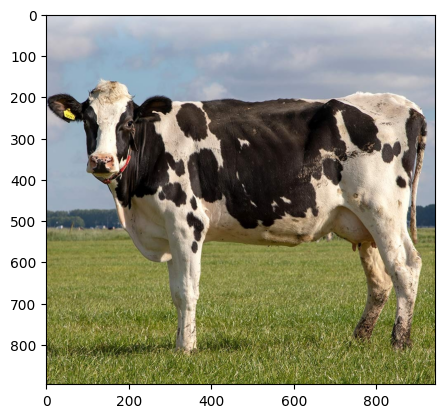

In [24]:
# Read image
img = cv2.imread('./cropped.jpg')

plt.imshow(img[:,:,::-1])
plt.show()

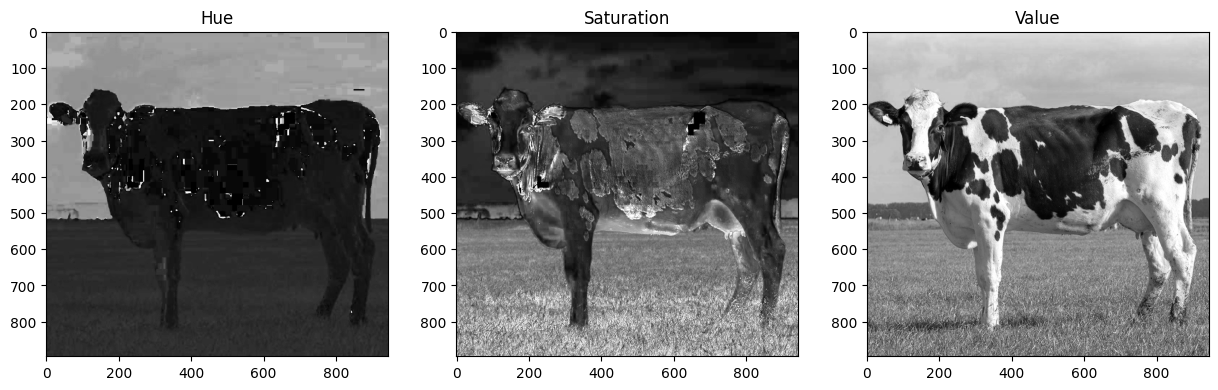

In [25]:
hsv = rgb2hsv(img)
h, s, v = split(hsv)

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow(h, cmap='gray')
plt.title('Hue')
plt.subplot(1, 3, 2)
plt.imshow(s, cmap='gray')
plt.title('Saturation')
plt.subplot(1, 3, 3)
plt.imshow(v, cmap='gray')
plt.title('Value')
plt.show()

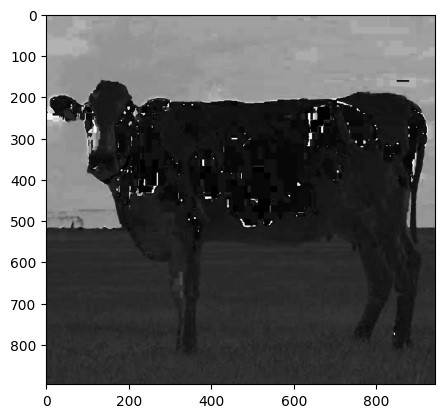

In [26]:
img_hue = h

plt.imshow(img_hue, cmap='gray')
plt.show()

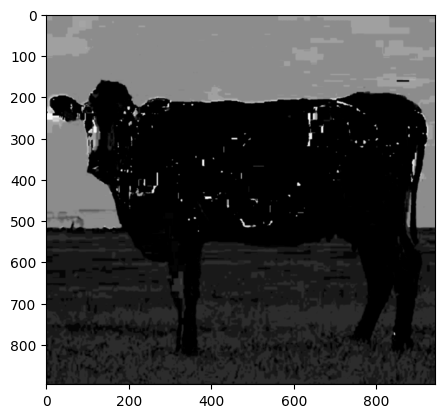

In [27]:
blur_hue = blur(img_hue, 3, 2)

plt.imshow(blur_hue, cmap='gray')
plt.show()

In [57]:
cv2.imwrite('./blur_hue.jpg', np.array(blur_hue))

True

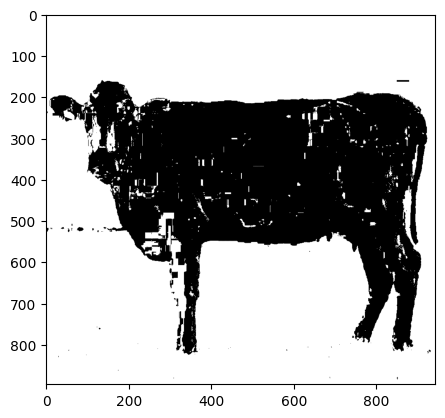

In [28]:
binary_hue = binary(img_hue, 23)

plt.imshow(binary_hue, cmap='gray')
plt.show()

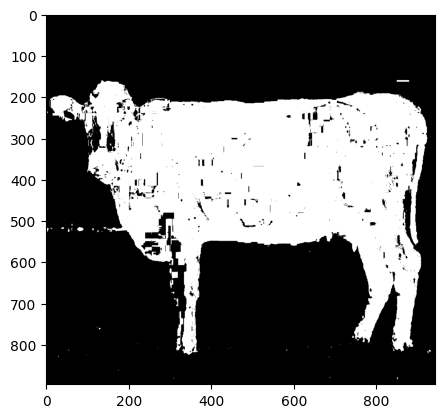

In [29]:
invert_hue = invert(binary_hue)

plt.imshow(invert_hue, cmap='gray')
plt.show()

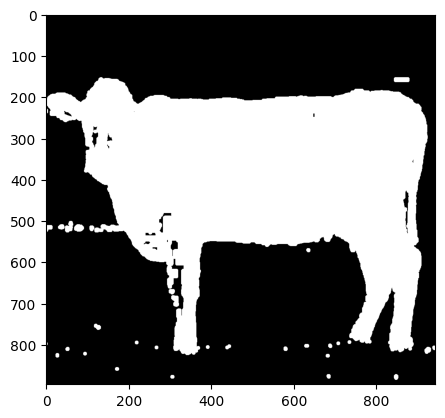

In [32]:
closing_hue = morph(invert_hue, 9, 5, "closing")

plt.imshow(closing_hue, cmap='gray')
plt.show()

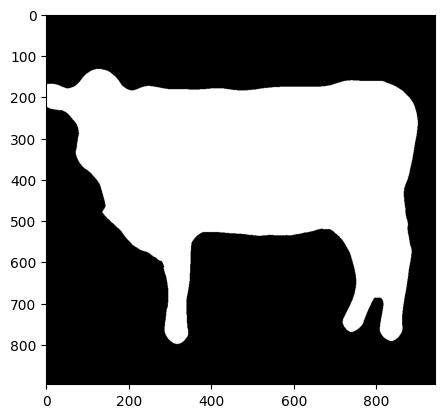

In [34]:
filtered_hue = median_filter(closing_hue, 49)

plt.imshow(filtered_hue, cmap='gray')
plt.show()